## Here we will try to use convolution model: $\sum_t r_{t - 1, t}^2 * w_t$, where w_i will be fit, r - returns

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from utils import rmspe

In [40]:
from sklearn.model_selection import train_test_split

In [25]:
train_targets = pd.read_csv('train.csv')

In [26]:
import os
import re
stock_ids = sorted(
    [int(re.sub('stock_id=', '', x)) for x in os.listdir('book_train.parquet')])

In [384]:
stock_id = stock_ids[0]

In [385]:
book = pd.read_parquet('book_train.parquet/stock_id=' + str(stock_id))
trades = pd.read_parquet('trade_train.parquet/stock_id=' + str(stock_id))

In [386]:
book['wap'] = (book['bid_price1'] * book['ask_size1'] + book['ask_price1'] * book['bid_size1']) / (
    book['ask_size1'] + book['bid_size1'])
    
book['log_price'] = np.log(book['wap'])
book['bucket_in_bucket'] = book['seconds_in_bucket'] // 100
book['log_return'] = book.groupby(['time_id', 'bucket_in_bucket'])['log_price'].diff()
book['square_return'] = book['log_return'] ** 2
book = book[~book['log_return'].isnull()]
book['stock_id'] = stock_id

In [387]:
book['seconds_to_end'] = 600 - book['seconds_in_bucket']
book = pd.merge(book, train_targets, how='left', on=['time_id', 'stock_id'])

In [388]:
X = pd.pivot_table(book, 
                   values='square_return', 
                   columns=['seconds_in_bucket'], 
                   index='time_id', aggfunc='last')

X = X.fillna(0)
y = train_targets[train_targets.stock_id == stock_id].set_index('time_id')['target'].loc[X.index]

In [399]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [400]:
lr = 1
weights = np.ones(X_train.shape[1])
n_steps = 300

In [401]:
train_loss_history = []
test_loss_history = []

In [402]:
for n in trange(n_steps):
    train_loss = rmspe(y_train, np.dot(X_train, weights).clip(0) ** 0.5)
    test_loss = rmspe(y_test, np.dot(X_test, weights).clip(0) ** 0.5)
    
    y_pred = np.dot(X_train, weights).clip(min=0.0001 ** 2) ** 0.5
    
    reg = 1
    der = np.dot(((y_pred - y_train) / y_pred / y_train), X_train.values)
    
    weights -= lr * der
    weights = weights.clip(0)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    

100%|██████████| 300/300 [00:05<00:00, 54.04it/s]


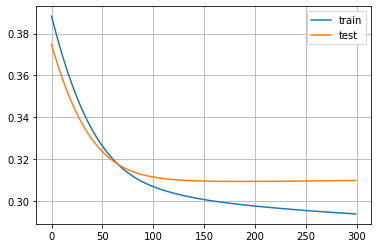

In [403]:
plt.plot(train_loss_history)
plt.plot(test_loss_history)

plt.legend(['train', 'test'])
plt.grid()

In [408]:
res = {}

for stock_id in tqdm(stock_ids):
    book = pd.read_parquet('book_train.parquet/stock_id=' + str(stock_id))
    book['wap'] = (book['bid_price1'] * book['ask_size1'] + book['ask_price1'] * book['bid_size1']) / (
    book['ask_size1'] + book['bid_size1'])
    
    book['log_price'] = np.log(book['wap'])
    book['bucket_in_bucket'] = book['seconds_in_bucket'] // 100
    book['log_return'] = book.groupby(['time_id', 'bucket_in_bucket'])['log_price'].diff()
    book['square_return'] = book['log_return'] ** 2
    book = book[~book['log_return'].isnull()]
    book['stock_id'] = stock_id
    
    
    book['seconds_to_end'] = 600 - book['seconds_in_bucket']
    book = pd.merge(book, train_targets, how='left', on=['time_id', 'stock_id'])
    
    X = pd.pivot_table(book, 
                   values='square_return', 
                   columns=['seconds_in_bucket'], 
                   index='time_id', aggfunc='last')

    X = X.fillna(0)
    y = train_targets[train_targets.stock_id == stock_id].set_index('time_id')['target'].loc[X.index]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    lr = 1
    weights = np.ones(X_train.shape[1])
    n_steps = 300
    
    train_loss_history = []
    test_loss_history = []
    
    for n in range(n_steps):
        train_loss = rmspe(y_train, np.dot(X_train, weights).clip(0) ** 0.5)
        test_loss = rmspe(y_test, np.dot(X_test, weights).clip(0) ** 0.5)

        y_pred = np.dot(X_train, weights).clip(min=0.0001 ** 2) ** 0.5

        reg = 1
        der = np.dot(((y_pred - y_train) / y_pred / y_train), X_train.values)

        weights -= lr * der
        weights = weights.clip(0)
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        
    res[stock_id] = (weights, X_train, y_train, X_test, y_test, train_loss_history, test_loss_history)
    



  0%|          | 0/112 [00:00<?, ?it/s]

  1%|          | 1/112 [00:10<19:48, 10.70s/it]

  2%|▏         | 2/112 [00:32<25:31, 13.92s/it]

  3%|▎         | 3/112 [00:47<26:14, 14.44s/it]

  4%|▎         | 4/112 [01:01<25:32, 14.19s/it]

  4%|▍         | 5/112 [01:14<24:38, 13.82s/it]

  5%|▌         | 6/112 [01:27<23:47, 13.47s/it]

  6%|▋         | 7/112 [01:40<23:29, 13.42s/it]

  7%|▋         | 8/112 [01:52<22:51, 13.19s/it]

  8%|▊         | 9/112 [02:06<22:50, 13.30s/it]

  9%|▉         | 10/112 [02:18<22:09, 13.03s/it]

 10%|▉         | 11/112 [02:33<22:37, 13.44s/it]

 11%|█         | 12/112 [02:46<22:10, 13.30s/it]

 12%|█▏        | 13/112 [03:00<22:17, 13.51s/it]

 12%|█▎        | 14/112 [03:15<22:52, 14.01s/it]

 13%|█▎        | 15/112 [03:29<22:39, 14.01s/it]

 14%|█▍        | 16/112 [03:42<21:47, 13.62s/it]

 15%|█▌        | 17/112 [03:56<21:43, 13.72s/it]

 16%|█▌        | 18/112 [04:10<21:47, 13.91s/it]

 17%|█▋        | 19/112 [04:28<23:17, 15.03s/it]

 18%|█▊        |

In [423]:
y_true = []
y_pred = []

for stock_id in tqdm(stock_ids):
    X_test = res[stock_id][1]
    y_test = res[stock_id][2]
    weights = res[stock_id][0]
    pred = np.dot(X_test, weights) ** 0.5
    
    y_true.append(y_test)
    y_pred.append(pred)



  0%|          | 0/112 [00:00<?, ?it/s]

 15%|█▌        | 17/112 [00:00<00:00, 167.37it/s]

 40%|████      | 45/112 [00:00<00:00, 189.75it/s]

 62%|██████▎   | 70/112 [00:00<00:00, 203.39it/s]

100%|██████████| 112/112 [00:00<00:00, 228.00it/s][A


In [424]:
rmspe(np.concatenate(y_true), np.concatenate(y_pred))

0.2579428113250401